In [1]:
import warnings
import matplotlib.animation as animation 
from IPython import display 
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
#from phi.flow import *  # minimal dependencies
# from phi.torch.flow import *
# from phi.tf.flow import *

from phi.jax.flow import *

In [3]:
Res       = 200   # Resolution
Walls = Obstacle(union(
    [Box(x=(20, 60), y=(48, 49)), #bottom wall
    Box(x=(85, 100), y=(76, 77)), #top bar
    Box(x=(20, 21), y=(48, 63)),
    Box(x=(48, 49), y=(48, 63)),
    Box(x=(34, 35), y=(80, 100)),
    Box(x=(34, 55), y=(90, 91)),
    Box(x=(76, 77), y=(80, 95)),
    ]
))


In [9]:
source_x = np.arange(0, 100, 14)
source_y = np.arange(0, 100, 14)

sources = [[x,y] for x in source_x for y in source_y]

print(sources)

# sources = [[98,84]]

[[0, 0], [0, 14], [0, 28], [0, 42], [0, 56], [0, 70], [0, 84], [0, 98], [14, 0], [14, 14], [14, 28], [14, 42], [14, 56], [14, 70], [14, 84], [14, 98], [28, 0], [28, 14], [28, 28], [28, 42], [28, 56], [28, 70], [28, 84], [28, 98], [42, 0], [42, 14], [42, 28], [42, 42], [42, 56], [42, 70], [42, 84], [42, 98], [56, 0], [56, 14], [56, 28], [56, 42], [56, 56], [56, 70], [56, 84], [56, 98], [70, 0], [70, 14], [70, 28], [70, 42], [70, 56], [70, 70], [70, 84], [70, 98], [84, 0], [84, 14], [84, 28], [84, 42], [84, 56], [84, 70], [84, 84], [84, 98], [98, 0], [98, 14], [98, 28], [98, 42], [98, 56], [98, 70], [98, 84], [98, 98]]


In [441]:
hf.close()

In [10]:
hf = h5py.File("Smoke-Flow-Data-2D-14-inch.h5", "w")


for source in sources:

    print('source at ', source)


    @jit_compile  # Only for PyTorch, TensorFlow and Jax
    def step(v, s, p, dt=1.):
        s = advect.mac_cormack(s, v, dt) + inflow
        buoyancy = resample(s * (0.0, 0.1), to=v)
        v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
        v, p = fluid.make_incompressible(v, Walls, Solve('auto', 1e-4, 0, x0=p))
        return v, s, p
    
    
    velocity = StaggeredGrid(0, x=Res, y=Res, bounds=Box(x=100, y=100))  # or CenteredGrid(...)
    smoke    = CenteredGrid(0, ZERO_GRADIENT, x=2*Res, y=2*Res, bounds=Box(x=100, y=100))
    inflow   = 0.05 * resample(Sphere(x=source[0], y=source[1], radius=5), to=smoke, soft=True)
    pressure = None
    
    
    trajectory = [smoke]

    for _ in range(500):
        velocity, smoke, pressure = step(velocity, smoke, pressure)
        trajectory.append(smoke)
        #     plot(vis.overlay(smoke,Walls.geometry), alpha=1, show_color_bar=False, animate='time')
    trajectory = field.stack(trajectory, batch('time'))
    g = hf.create_group(name = 'x-{}-y-{}'.format(source[0], source[1]))
    g.create_dataset('density', data=trajectory.uniform_values().numpy('time,x,y,vector'))
    g.attrs['SourcePosition'] = source


hf.close()

source at  [0, 0]
source at  [0, 14]
source at  [0, 28]
source at  [0, 42]
source at  [0, 56]
source at  [0, 70]
source at  [0, 84]
source at  [0, 98]
source at  [14, 0]


2024-05-11 23:53:55.274036: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.2627 = s64[196432,1]{1,0} slice(s64[196432,2]{0,1} %constant.581), slice={[0:196432], [0:1]}, metadata={op_name="jit(native(step))/jit(main)/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(0,), collapsed_slice_dims=(1,), start_index_map=(1,)) slice_sizes=(196432, 1) unique_indices=True indices_are_sorted=True mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/home/exouser/.local/lib/python3.9/site-packages/phiml/backend/jax/_jax_backend.py" source_line=381}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_du

source at  [14, 14]
source at  [14, 28]
source at  [14, 42]
source at  [14, 56]
source at  [14, 70]
source at  [14, 84]
source at  [14, 98]
source at  [28, 0]
source at  [28, 14]
source at  [28, 28]
source at  [28, 42]
source at  [28, 56]
source at  [28, 70]
source at  [28, 84]
source at  [28, 98]
source at  [42, 0]
source at  [42, 14]
source at  [42, 28]
source at  [42, 42]
source at  [42, 56]
source at  [42, 70]
source at  [42, 84]
source at  [42, 98]
source at  [56, 0]
source at  [56, 14]
source at  [56, 28]


OSError: [Errno 28] Can't write data (file write failed: time = Sun May 12 00:08:44 2024
, filename = 'Smoke-Flow-Data-2D-14-inch.h5', file descriptor = 90, errno = 28, error message = 'No space left on device', buf = 0x7f991faabe90, total write size = 8000896, bytes this sub-write = 8000896, bytes actually written = 18446744073709551615, offset = 0)

In [432]:
hf = h5py.File("temp.h5", "r")

In [433]:
names = hf.keys()
print(names)

<KeysViewHDF5 ['x-98-y-84']>


In [434]:
dd = hf['x-98-y-84']['density']

In [435]:
q = tensor(np.array(dd[:,:,:,0]), batch('time'), spatial('x,y'))
gridQ = CenteredGrid(q, bounds=Box(x=100, y=100))

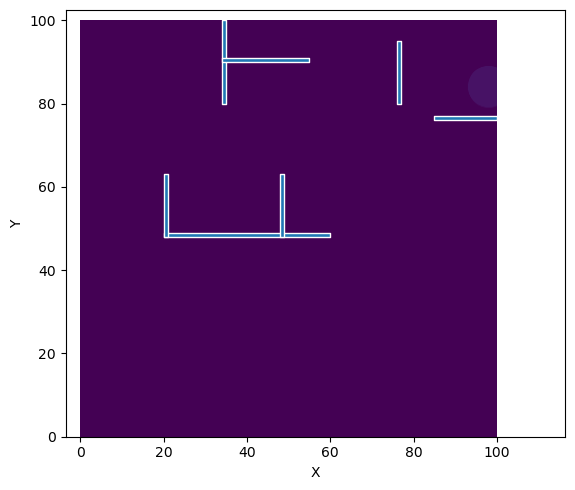

In [436]:
q = tensor(np.array(dd[1,:,:,0]), spatial('x,y'))
gridQ = CenteredGrid(q, bounds=Box(x=100, y=100))
p = plot(vis.overlay(gridQ,Walls.geometry), alpha=1,
     show_color_bar=False)

In [116]:
# plot(vis.overlay(gridQ,Walls.geometry), alpha=1,
#      show_color_bar=False, animate='time')

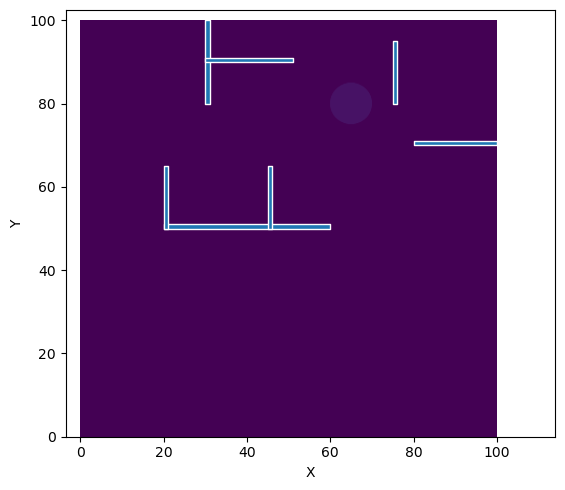

In [117]:
p = plot(vis.overlay(gridQ,Walls.geometry), alpha=1,
     show_color_bar=False, animate='time')

In [12]:
# p.save('Smoke-x-20.mp4')

(16.0, 104.0, 47.5, 102.5)

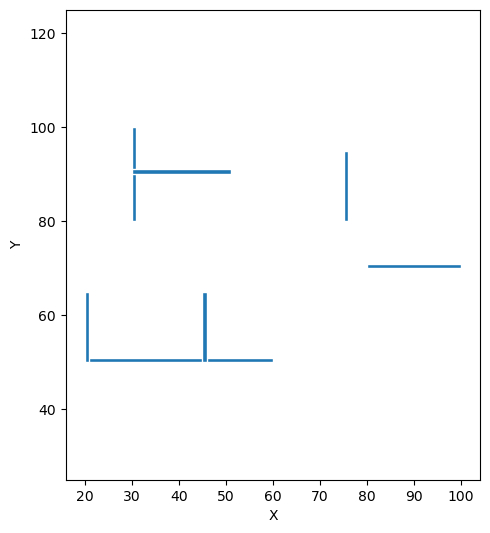

In [10]:
plot(vis.overlay(Walls.geometry, ), alpha=1, size = (5,5))
plt.axis('equal')